<a href="https://colab.research.google.com/github/WilhelmWillie/i-love-produce/blob/master/i_love_produce_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the i-love-produce repo and get latest test data

!git clone https://github.com/WilhelmWillie/i-love-produce.git

fatal: destination path 'i-love-produce' already exists and is not an empty directory.


In [2]:
# Verify we have a test, train, and validation folder
!ls i-love-produce/dataset

test  train  validation


In [0]:
# Importing the right libraries

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

import os 
import time 

In [4]:
# Set up paths for training and validation directory
base_dir = os.path.join(os.getcwd(), 'i-love-produce', 'dataset')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(base_dir, train_dir, validation_dir, test_dir)

/content/i-love-produce/dataset /content/i-love-produce/dataset/train /content/i-love-produce/dataset/validation /content/i-love-produce/dataset/test


In [0]:
# Count number of training and validation datapoints
train_tomato_dir = os.path.join(train_dir, 'tomato')
train_carrot_dir = os.path.join(train_dir, 'carrot')
train_onion_dir = os.path.join(train_dir, 'onion')

validation_tomato_dir = os.path.join(validation_dir, 'tomato')
validation_carrot_dir = os.path.join(validation_dir, 'carrot')
validation_onion_dir = os.path.join(validation_dir, 'onion')

num_tomato_tr = len(os.listdir(train_tomato_dir))
num_carrot_tr = len(os.listdir(train_carrot_dir))
num_onion_tr = len(os.listdir(train_onion_dir))

num_tomato_val = len(os.listdir(validation_tomato_dir))
num_carrot_val = len(os.listdir(validation_carrot_dir))
num_onion_val = len(os.listdir(validation_onion_dir))

total_train = num_tomato_tr + num_carrot_tr + num_onion_tr
total_val = num_tomato_val + num_carrot_val + num_onion_val

In [0]:
# Key variables
IMAGE_RES = 224
BATCH_SIZE = 40
NUM_CLASSES = 3

In [7]:
# Set up training data w/ image augmentation
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='sparse',
                                                     color_mode='rgb'
                                                    )

Found 160 images belonging to 3 classes.


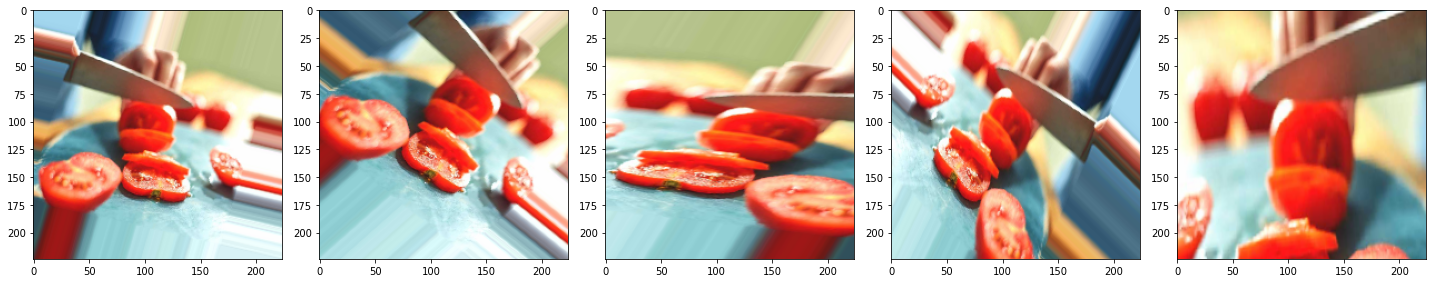

In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [9]:
# Set up validation data w/ no image augmentation
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMAGE_RES, IMAGE_RES),
                                                 class_mode='sparse',
                                                 color_mode='rgb')

Found 60 images belonging to 3 classes.


In [10]:
# Set up our model which is a CNN w/ some dropout
FEATURE_VECTOR_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(FEATURE_VECTOR_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False

model = tf.keras.models.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Train our model with a set number of epochs
epochs = 40

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/40
4/4 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.4062

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4/4 [==============================] - 4s 1s/step - loss: 1.0868 - accuracy: 0.4062 - val_loss: 0.9873 - val_accuracy: 0.6500
Epoch 2/40
4/4 [==============================] - 4s 1s/step - loss: 0.9165 - accuracy: 0.6812 - val_loss: 0.8372 - val_accuracy: 0.8500
Epoch 3/40
4/4 [==============================] - 4s 1s/step - loss: 0.7919 - accuracy: 0.8062 - val_loss: 0.7408 - val_accuracy: 0.9167
Epoch 4/40
4/4 [==============================] - 4s 1s/step - loss: 0.7088 - accuracy: 0.8938 - val_loss: 0.6897 - val_accuracy: 0.9333
Epoch 5/40
4/4 [==============================] - 4s 1s/step - loss: 0.6672 - accuracy: 0.9312 - val_loss: 0.6598 - val_accuracy: 0.9333
Epoch 6/40
4/4 [==============================] - 5s 1s/step - loss: 0.6378 - accuracy: 0.9625 - val_loss: 0.6409 - val_accuracy: 0.9333
Epoch 7/40
4/4 [==============================] - 5s 1s/step - loss: 0.6170 - accuracy: 0.9750 - val_loss: 0.6278 - val_accuracy: 0.9500
Epoch 8/40
4/4 [==============================] - 5s

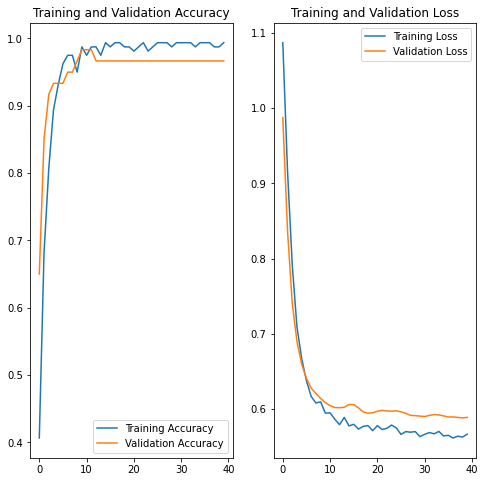

In [12]:
# Plot our training metrics (potentially identify room for improvement)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Set up our test data
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(directory=test_dir,
                                                 target_size=(IMAGE_RES, IMAGE_RES),
                                                 class_mode='sparse',
                                                 color_mode='rgb')

Found 15 images belonging to 3 classes.


In [14]:
# Evaluate with our test data generator
test_data_gen.reset()
model.evaluate(test_data_gen)

1/1 [==============================] - 0s 1ms/step - loss: 0.6239 - accuracy: 0.9333


[0.6239058375358582, 0.9333333373069763]

Class names:  ['carrot' 'onion' 'tomato']

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


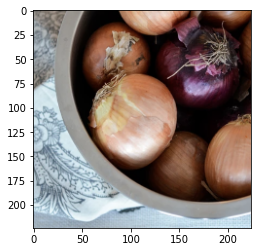

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


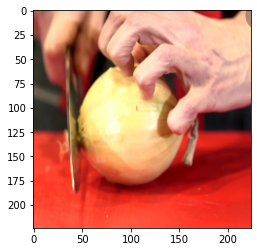

Image shape:  (224, 224, 3)
Label:  carrot
Predicted Label:  carrot


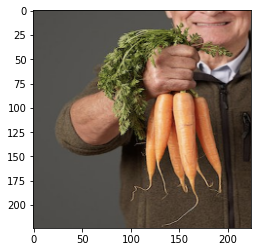

Image shape:  (224, 224, 3)
Label:  tomato
Predicted Label:  tomato


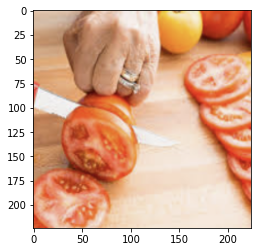

Image shape:  (224, 224, 3)
Label:  carrot
Predicted Label:  carrot


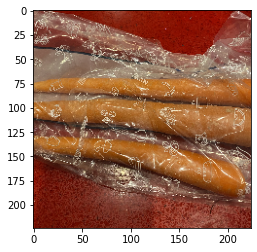

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


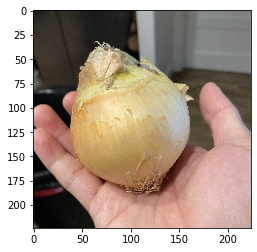

Image shape:  (224, 224, 3)
Label:  tomato
Predicted Label:  tomato


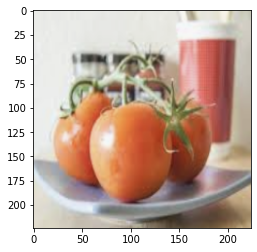

Image shape:  (224, 224, 3)
Label:  tomato
Predicted Label:  tomato


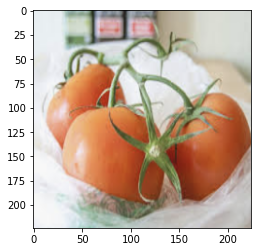

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


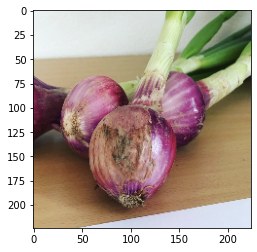

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


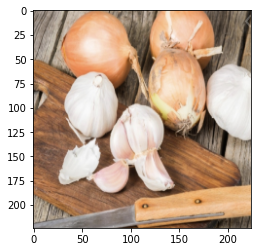

Image shape:  (224, 224, 3)
Label:  carrot
Predicted Label:  carrot


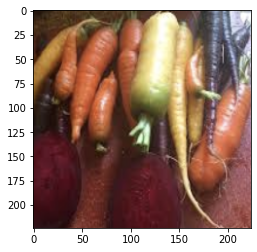

Image shape:  (224, 224, 3)
Label:  tomato
Predicted Label:  tomato


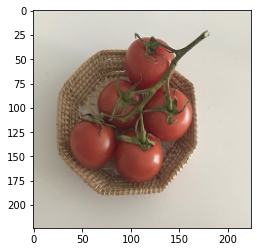

Image shape:  (224, 224, 3)
Label:  carrot
Predicted Label:  carrot


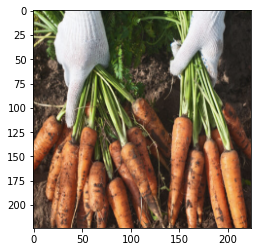

Image shape:  (224, 224, 3)
Label:  carrot
Predicted Label:  onion


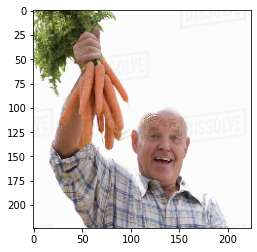

Image shape:  (224, 224, 3)
Label:  onion
Predicted Label:  onion


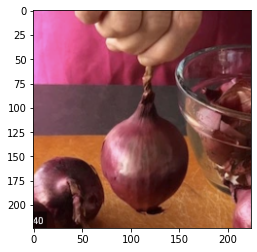

In [21]:
# Let's visualize some predictions
list_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'test', '*/*'))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMAGE_RES, IMAGE_RES])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

CLASS_NAMES = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
CLASS_NAMES = np.array([key for key, value in CLASS_NAMES])

print("Class names: ", CLASS_NAMES)
print()

for image, label in labeled_ds.take(15):
  print("========")
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().decode("utf-8"))
  pred = model.predict(image[np.newaxis, ...])
  predicted_class = np.argmax(pred[0], axis=-1)
  print("Predicted Label: ", CLASS_NAMES[predicted_class])
  plt.imshow(image)
  plt.show()

In [16]:
# If model is good, save it!
t = time.time()
file_name = int(t)

export_path_sm = "./{}".format(file_name)
tf.saved_model.save(model, export_path_sm)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1590170265/assets


INFO:tensorflow:Assets written to: ./1590170265/assets


In [17]:
!zip model.zip -r $file_name

  adding: 1590170265/ (stored 0%)
  adding: 1590170265/saved_model.pb (deflated 92%)
  adding: 1590170265/assets/ (stored 0%)
  adding: 1590170265/variables/ (stored 0%)
  adding: 1590170265/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: 1590170265/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: 1590170265/variables/variables.index (deflated 79%)
